# Modularity Analysis Results Plotting

This notebook plots modularity analysis results from CSV files generated by `analyze.py`.

## Available Results Files:
- `results/global_modularity.csv` - Global network modularity (all votes combined)
- `results/topic_modularity.csv` - Per-topic network modularity

## Usage:
1. Run `analyze.py` to generate CSV files
2. Execute cells below to visualize results


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths - results are stored inside modularity_analysis/results/
# This notebook should be run from the modularity_analysis folder or project root
if Path.cwd().name == 'modularity_analysis':
    # Running from inside modularity_analysis folder
    RESULTS_DIR = Path.cwd() / "results"
else:
    # Running from project root
    RESULTS_DIR = Path("modularity_analysis") / "results"

GLOBAL_CSV = RESULTS_DIR / "global_modularity.csv"
TOPIC_CSV = RESULTS_DIR / "topic_modularity.csv"

print(f"Current working directory: {Path.cwd()}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Global CSV exists: {GLOBAL_CSV.exists()}")
print(f"Topic CSV exists: {TOPIC_CSV.exists()}")


Current working directory: /Users/nicolalorusso/Locale/EP_project/modularity_analysis
Results directory: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results
Global CSV exists: True
Topic CSV exists: False


## Plot Global Modularity Evolution


Loaded global data: 5 EPs
✅ Saved plot: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/global_modularity_evolution.png


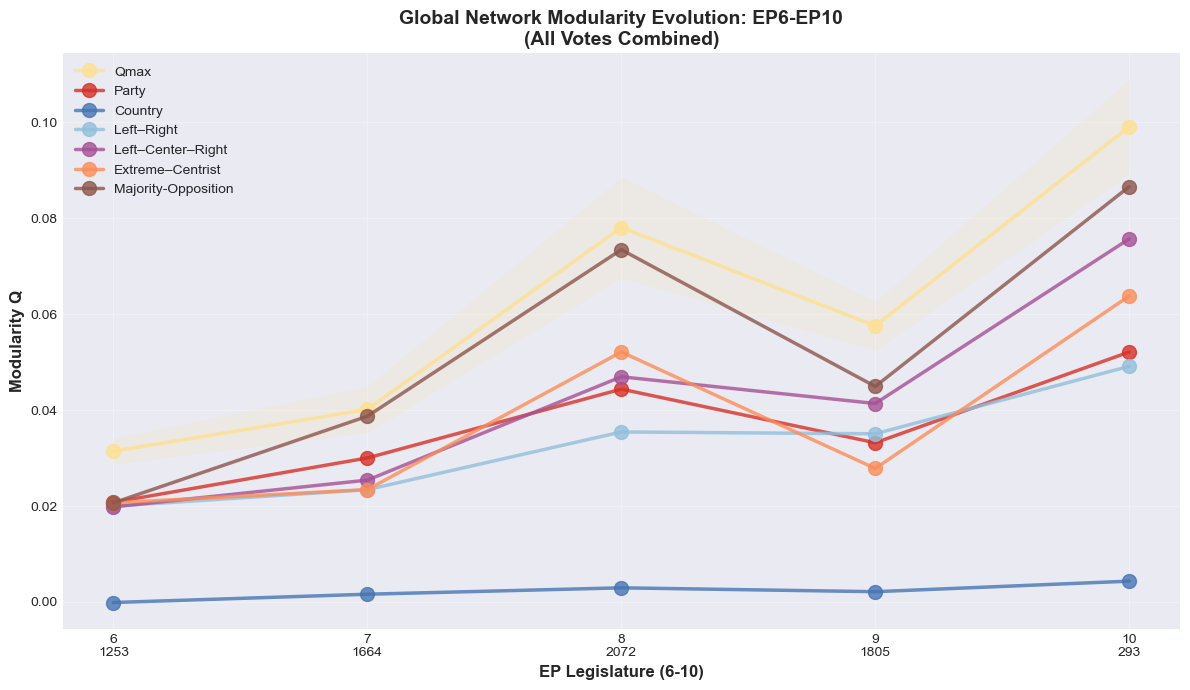

In [25]:
def plot_global_modularity(df, save_path=None):
    """Plot global network modularity evolution."""
    if df is None or df.empty:
        print("⚠️  No global modularity data available.")
        return
    
    # Check available metrics
    mod_cols = [
        "qmax",
        "qparty",
        "qcountry",
        "q_left_right",
        "q_left_center_right",
        "q_extreme_centrist",
        "q_majority_opposition",
    ]
    available_cols = [c for c in mod_cols if c in df.columns and df[c].notna().any()]
    
    if not available_cols:
        print("⚠️  No modularity data found.")
        return
    
    # Sort by EP
    df = df.sort_values("ep")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    colors = {
        "qmax": "#fee090",
        "q_extreme_centrist": "#fc8d59",
        "q_majority_opposition": "#8c564b",
        "qparty": "#d73027",
        "q_left_right": "#91bfdb",
        "q_left_center_right": "#a55194",
        "qcountry": "#4575b4",
    }
    
    labels = {
        "qmax": "Qmax",
        "q_extreme_centrist": "Extreme–Centrist",
        "q_majority_opposition": "Majority-Opposition",
        "qparty": "Party",
        "q_left_right": "Left–Right",
        "q_left_center_right": "Left–Center–Right",
        "qcountry": "Country",
    }
    
    x = df["ep"].to_numpy()
    
    # Check for subsample std (preferred) or regular std
    if "qmax_subsample_std" in df.columns:
        qmax_std_series = df["qmax_subsample_std"]
    elif "qmax_std" in df.columns:
        qmax_std_series = df["qmax_std"]
    else:
        qmax_std_series = None
    
    # Plot each measure
    for measure in available_cols:
        y = df[measure].to_numpy()
        valid = np.isfinite(y)
        if valid.sum() < 2:
            continue
        y_valid = y[valid]
        ax.plot(x[valid], y_valid, marker="o", linewidth=2.5, markersize=10,
               color=colors[measure], label=labels[measure], alpha=0.8)
        
        # Add confidence interval for Qmax
        if measure == "qmax" and qmax_std_series is not None:
            std_vals = qmax_std_series.to_numpy()[valid]
            if len(std_vals) == len(y_valid):
                ax.fill_between(
                    x[valid],
                    y_valid - std_vals,
                    y_valid + std_vals,
                    color=colors[measure],
                    alpha=0.15,
                    linewidth=0,
                )
    
    # Create tick labels with vote counts and flags
    tick_labels = []
    for ep in x:
        label = f"{int(ep)}"
        row = df[df["ep"] == ep].iloc[0]
        
        votes_val = row.get("votes_used")
        flags = ""
        # if row.get("bootstrapped", False):
        #     flags += "B"
        # if row.get("downsampled", False):
        #     flags += "D"
        
        if pd.notna(votes_val) and not (isinstance(votes_val, float) and np.isnan(votes_val)):
            votes_label = f"{int(votes_val)}"
            if flags:
                votes_label += f"({flags})"
            label += f"\n{votes_label}"
        elif flags:
            label += f"\n({flags})"
        tick_labels.append(label)
    
    ax.set_xticks(x)
    ax.set_xticklabels(tick_labels)
    
    ax.set_xlabel("EP Legislature (6-10)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Modularity Q", fontsize=12, fontweight="bold")
    ax.set_title("Global Network Modularity Evolution: EP6-EP10\n(All Votes Combined)", 
                 fontsize=14, fontweight="bold")
    ax.legend(frameon=False, loc="best", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved plot: {save_path}")
    else:
        plt.show()
    
    #plt.close(fig)


# Load and plot global data
if GLOBAL_CSV.exists():
    df_global = pd.read_csv(GLOBAL_CSV)
    print(f"Loaded global data: {len(df_global)} EPs")
    plot_global_modularity(df_global, save_path=RESULTS_DIR / "global_modularity_evolution.png")
else:
    print("⚠️  Global CSV not found. Run: python analyze.py --global")


## Plot Per-Topic Modularity Evolution


In [53]:
def plot_topic_modularity_evolution(df, topic_name=None, save_path=None):
    """Plot modularity evolution for a specific topic or all topics."""
    if df is None or df.empty:
        print("⚠️  No topic modularity data available.")
        return
    
    # Filter by topic if specified
    if topic_name:
        df = df[df["topic"].str.contains(topic_name, case=False, na=False)]
        if df.empty:
            print(f"⚠️  No data found for topic: {topic_name}")
            return
    
    # Get unique topics
    topics = df["topic"].unique()
    print(f"Found {len(topics)} topic(s)")
    
    # Plot each topic
    for topic in topics:
        df_topic = df[df["topic"] == topic].sort_values("ep")
        
        if len(df_topic) < 2:
            print(f"  ⚠️  Topic '{topic}' has insufficient data, skipping...")
            continue
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        mod_cols = [
            "qmax",
            "qparty",
            "qcountry",
            "q_left_right",
            "q_left_center_right",
            "q_extreme_centrist",
            "q_majority_opposition",
        ]
        available_cols = [c for c in mod_cols if c in df_topic.columns and df_topic[c].notna().any()]
        
        colors = {
            "qmax": "#fee090",
            "q_extreme_centrist": "#fc8d59",
            "q_majority_opposition": "#8c564b",
            "qparty": "#d73027",
            "q_left_right": "#91bfdb",
            "q_left_center_right": "#a55194",
            "qcountry": "#4575b4",
        }
        
        labels = {
            "qmax": "Qmax",
            "q_extreme_centrist": "Extreme–Centrist",
            "q_majority_opposition": "Majority-Opposition",
            "qparty": "Party",
            "q_left_right": "Left–Right",
            "q_left_center_right": "Left–Center–Right",
            "qcountry": "Country",
        }
        
        x = df_topic["ep"].to_numpy()
        
        for measure in available_cols:
            y = df_topic[measure].to_numpy()
            valid = np.isfinite(y)
            if valid.sum() < 2:
                continue
            y_valid = y[valid]
            x_valid = x[valid]
            
            # For qmax, add error bars with standard deviation
            if measure == "qmax":
                # Try to get standard deviation (prefer subsample_std if available)
                std_col = None
                if "qmax_subsample_std" in df_topic.columns:
                    std_col = "qmax_subsample_std"
                elif "qmax_std" in df_topic.columns:
                    std_col = "qmax_std"
                
                if std_col:
                    yerr = df_topic[std_col].to_numpy()[valid]
                    # Only use finite error values
                    yerr_valid = np.where(np.isfinite(yerr), yerr, 0)
                    ax.errorbar(x_valid, y_valid, yerr=yerr_valid, 
                              marker="o", linewidth=2.5, markersize=10,
                              color=colors[measure], label=labels[measure], 
                              alpha=0.8, capsize=5, capthick=2, elinewidth=1.5)
                else:
                    # No std available, plot without error bars
                    ax.plot(x_valid, y_valid, marker="o", linewidth=2.5, markersize=10,
                           color=colors[measure], label=labels[measure], alpha=0.8)
            else:
                # For other measures, plot normally
                ax.plot(x_valid, y_valid, marker="o", linewidth=2.5, markersize=10,
                       color=colors[measure], label=labels[measure], alpha=0.8)
        
        ax.set_xticks(x)
        ax.set_xticklabels([int(ep) for ep in x])
        ax.set_xlabel("EP Legislature", fontsize=12, fontweight="bold")
        ax.set_ylabel("Modularity Q", fontsize=12, fontweight="bold")
        ax.set_title(f"Modularity Evolution: {topic}", fontsize=14, fontweight="bold")
        ax.legend(frameon=False, loc="best", fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            # Create topic-specific filename
            topic_slug = topic.lower().replace(" ", "_").replace("/", "_")
            topic_path = save_path.parent / f"topic_{topic_slug}_evolution.png"
            fig.savefig(topic_path, dpi=300, bbox_inches="tight")
            print(f"  ✅ Saved: {topic_path}")
        else:
            plt.show()
        
        plt.close(fig)


# Load and plot topic data
if TOPIC_CSV.exists():
    df_topics = pd.read_csv(TOPIC_CSV)
    print(f"Loaded topic data: {len(df_topics)} rows")
    print(f"Unique topics: {df_topics['topic'].nunique()}")
    print(f"EPs covered: {sorted(df_topics['ep'].unique())}")
    
    # Plot all topics
    plot_topic_modularity_evolution(df_topics, save_path=RESULTS_DIR / "topic_evolution.png")
    
    # Show summary
    print("\n" + "="*80)
    print("TOPIC SUMMARY")
    print("="*80)
    summary = df_topics.groupby("topic").agg({
        "ep": "count",
        "qmax": ["mean", "max"],
        "qparty": "mean"
    }).round(4)
    print(summary)
else:
    print("⚠️  Topic CSV not found. Run: python analyze.py --topics")


Loaded topic data: 103 rows
Unique topics: 21
EPs covered: [6, 7, 8, 9, 10]
Found 21 topic(s)
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_foreign_affairs_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_industry,_research_and_energy_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_environment_and_health_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_women's_rights_and_gender_equality_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_budgets_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_international_trade_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/topic_budgetary_control_evolution.png
  ✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/

In [51]:
# ============================================================================
# BAR GRAPHS: Modularity per Topic per Legislature
# ============================================================================

def plot_modularity_bars_per_ep(df_topics: pd.DataFrame, save_dir: Path = None):
    """
    Create bar graphs showing modularity metrics for all topics per EP.
    Similar to regenerate_modularity_plots.py but adapted for notebook use.
    """
    if df_topics.empty:
        print("⚠️  No topic data available")
        return
    
    # Colors matching modularity.py
    colors = {
        "qmax": "#fee090",
        "q_extreme_centrist": "#fc8d59",
        "qparty": "#d73027",
        "q_left_right": "#91bfdb",
        "qcountry": "#4575b4",
        "q_majority_opposition": "#8c564b",
        "q_left_center_right": "#74add1",
    }
    
    label_map = {
        "qmax": "Qmax",
        "q_extreme_centrist": "Extreme–Centrist",
        "qparty": "Party",
        "q_left_right": "Left–Right",
        "qcountry": "Country",
        "q_majority_opposition": "Majority vs Opposition",
        "q_left_center_right": "Left–Center–Right",
    }
    
    # Filter out ratio and std columns for plotting
    mod_cols = [c for c in df_topics.columns if c.startswith("q") and c not in (
        "qmax_std", "qmax_subsample_std",
        "qparty_qmax_ratio", "qparty_qmax_ratio_subsample_std",
        "qcountry_qmax_ratio", "qcountry_qmax_ratio_subsample_std", 
        "q_left_right_qmax_ratio", "q_left_right_qmax_ratio_subsample_std",
        "q_extreme_centrist_qmax_ratio", "q_extreme_centrist_qmax_ratio_subsample_std",
        "q_majority_opposition_qmax_ratio", "q_majority_opposition_qmax_ratio_subsample_std",
        "q_left_center_right_qmax_ratio", "q_left_center_right_qmax_ratio_subsample_std",
        "q_left_right_subsample_std", "qcountry_subsample_std", "qparty_subsample_std",
        "q_extreme_centrist_subsample_std", "q_majority_opposition_subsample_std",
        "q_left_center_right_subsample_std"
    )]
    
    # Process each EP
    for ep in sorted(df_topics["ep"].unique()):
        ep_df = df_topics[df_topics["ep"] == ep].copy()
        
        if ep_df.empty:
            print(f"⚠️  EP{ep}: No data, skipping")
            continue
        
        # Filter to rows with modularity data
        has_mod = ep_df[mod_cols].notna().any(axis=1)
        ep_df = ep_df[has_mod].copy()
        
        if ep_df.empty:
            print(f"⚠️  EP{ep}: No modularity data, skipping")
            continue
        
        # Sort by Qmax (descending)
        if "qmax" in ep_df.columns:
            ep_df = ep_df.sort_values("qmax", ascending=False, na_position='last')
        
        # Prepare topic labels with vote counts
        topics = []
        for _, row in ep_df.iterrows():
            topic_label = row["topic"]
            vote_count = row.get("votes_used", None)
            if pd.notna(vote_count):
                topics.append(f"{topic_label} ({int(vote_count)})")
            else:
                topics.append(topic_label)
        
        n_topics = len(topics)
        if n_topics == 0:
            continue
        
        # Create bar plot with spacing between topics
        fig, ax = plt.subplots(figsize=(max(14, n_topics * 0.8), 6))
        spacing = 1.2  # Space multiplier between topics
        x = np.arange(n_topics) * spacing
        width = 0.15
        
        # Collect which measures we have (in desired order)
        available_measures = []
        measure_order = ["qmax", "q_majority_opposition", "q_left_center_right", "q_left_right", 
                        "q_extreme_centrist", "qparty", "qcountry"]
        for measure in measure_order:
            if measure in ep_df.columns and ep_df[measure].notna().any():
                available_measures.append(measure)
        
        n_measures = len(available_measures)
        if n_measures == 0:
            print(f"⚠️  EP{ep}: No available measures, skipping")
            plt.close(fig)
            continue
        
        # Center bars around x
        total_width = n_measures * width
        start_offset = -total_width / 2 + width / 2
        
        # Plot each modularity measure
        for idx, measure in enumerate(available_measures):
            offset = start_offset + idx * width
            values = ep_df[measure].fillna(0).tolist()
            ax.bar(x + offset, values, width, color=colors.get(measure, "#999999"), 
                   label=label_map.get(measure, measure), alpha=0.9)
        
        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels(topics, rotation=45, ha="right", fontsize=9)
        ax.set_ylabel("Modularity Q", fontsize=12, fontweight="bold")
        ax.set_title(f"Modularity values by topic: EP{ep}", fontsize=14, fontweight="bold")
        ax.legend(frameon=False, loc="upper right", fontsize=9)
        ax.grid(axis="y", alpha=0.3)
        
        plt.tight_layout()
        
        # Save or display
        if save_dir:
            plot_path = save_dir / f"modularity_by_topic_EP{ep}.png"
            fig.savefig(plot_path, dpi=300, bbox_inches="tight")
            print(f"✅ Saved: {plot_path}")
        else:
            plt.show()
        
        plt.close(fig)


# Generate bar graphs for all EPs
if TOPIC_CSV.exists():
    df_topics = pd.read_csv(TOPIC_CSV)
    print(f"Generating modularity bar graphs per EP...")
    print(f"Loaded {len(df_topics)} topic records")
    plot_modularity_bars_per_ep(df_topics, save_dir=RESULTS_DIR)
    print("\n✅ All bar graphs generated!")
else:
    print("⚠️  Topic CSV not found. Run: python analyze.py --topics")


Generating modularity bar graphs per EP...
Loaded 103 topic records
✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/modularity_by_topic_EP6.png
✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/modularity_by_topic_EP7.png
✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/modularity_by_topic_EP8.png
✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/modularity_by_topic_EP9.png
✅ Saved: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/modularity_by_topic_EP10.png

✅ All bar graphs generated!


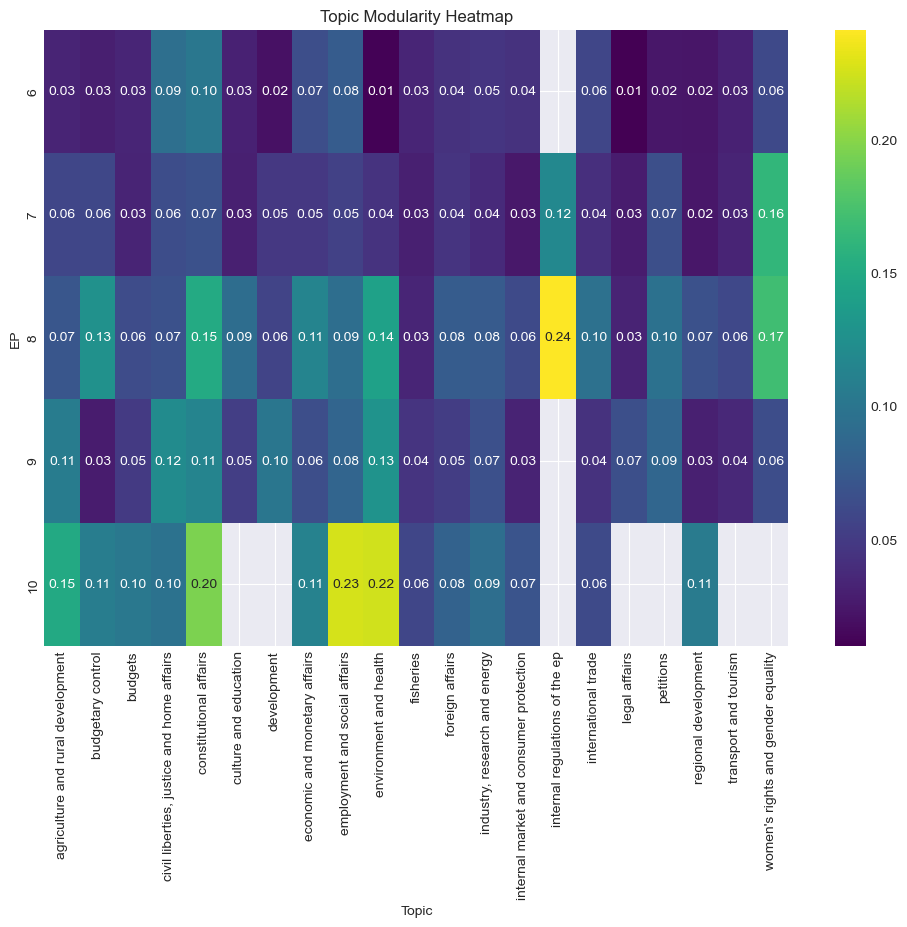

In [55]:
# plot a heatmap of the topic modularity

# dont plot the ones with less than 5 votes
df_topics = df_topics[df_topics["votes_used"] >= 5]

plt.figure(figsize=(12, 8))
sns.heatmap(df_topics.pivot(index="ep", columns="topic", values="qmax"), cmap="viridis", annot=True, fmt=".2f")
plt.title("Topic Modularity Heatmap")
plt.xlabel("Topic")
plt.ylabel("EP")
plt.show()

## Plot Agreement Distribution

Visualize the distribution of agreement scores between MEP pairs.


Computing agreement distribution for EP6 - Global (All Main Votes)
  MEPs: 841, Votes: 1253
  Total MEP pairs: 353220
  Pairs with no overlapping votes (excluded): 2848
  Pairs with overlapping votes: 350372
  Pairs with exact 0 agreement (perfect disagreement): 6
  Pairs with agreement < 0.01 (very low): 4402
  Mean agreement: 0.6944
  Median agreement: 0.7945
  Std agreement: 0.2400
✅ Saved plot: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/agreement_distribution_EP6_global.png
Computing agreement distribution for EP7 - Global (All Main Votes)
  MEPs: 812, Votes: 1664
  Total MEP pairs: 329266
  Pairs with no overlapping votes (excluded): 1967
  Pairs with overlapping votes: 327299
  Pairs with exact 0 agreement (perfect disagreement): 3
  Pairs with agreement < 0.01 (very low): 537
  Mean agreement: 0.6605
  Median agreement: 0.7893
  Std agreement: 0.2686
✅ Saved plot: /Users/nicolalorusso/Locale/EP_project/modularity_analysis/results/agreement_distribution_EP

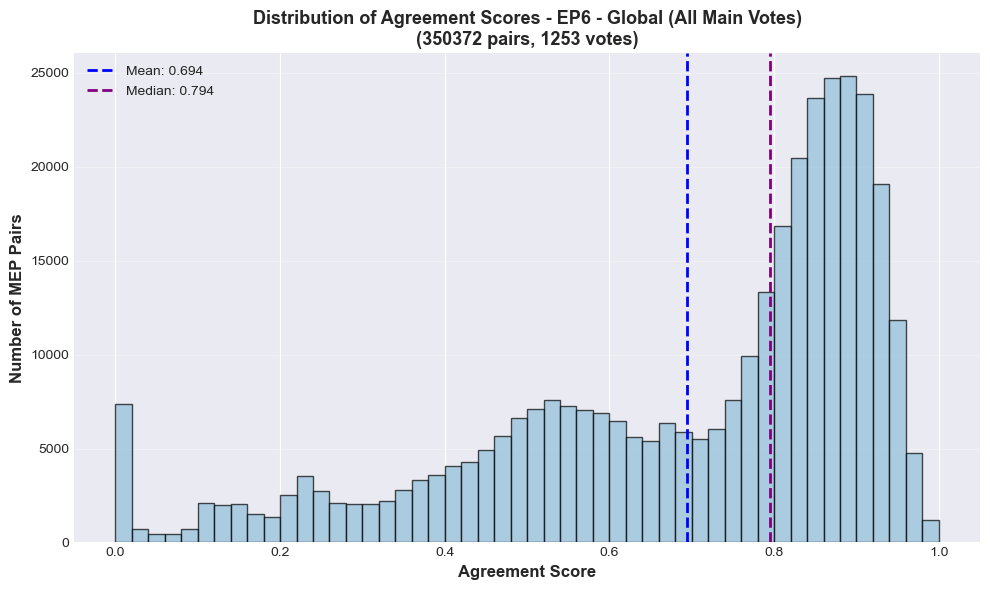

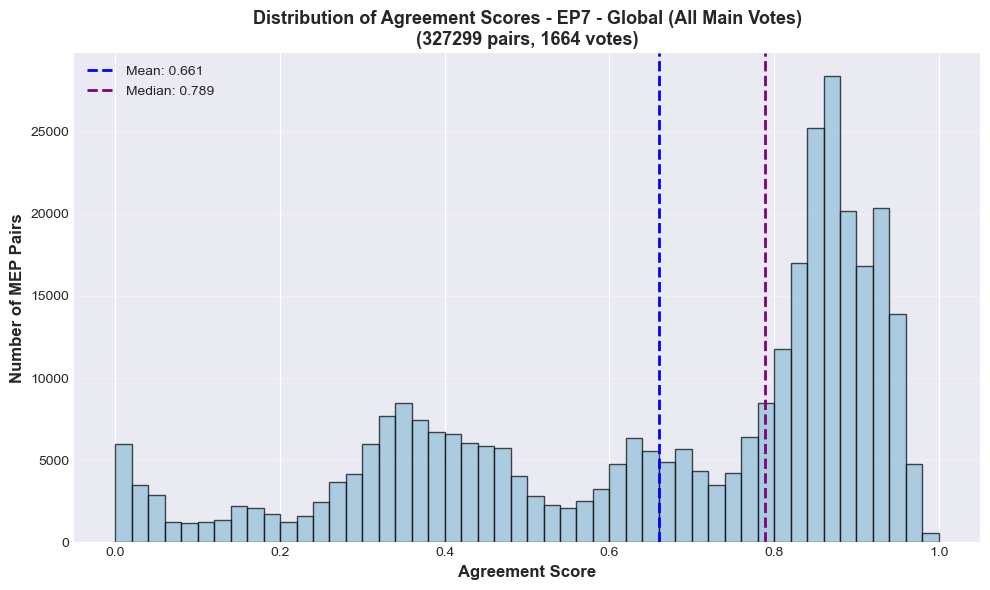

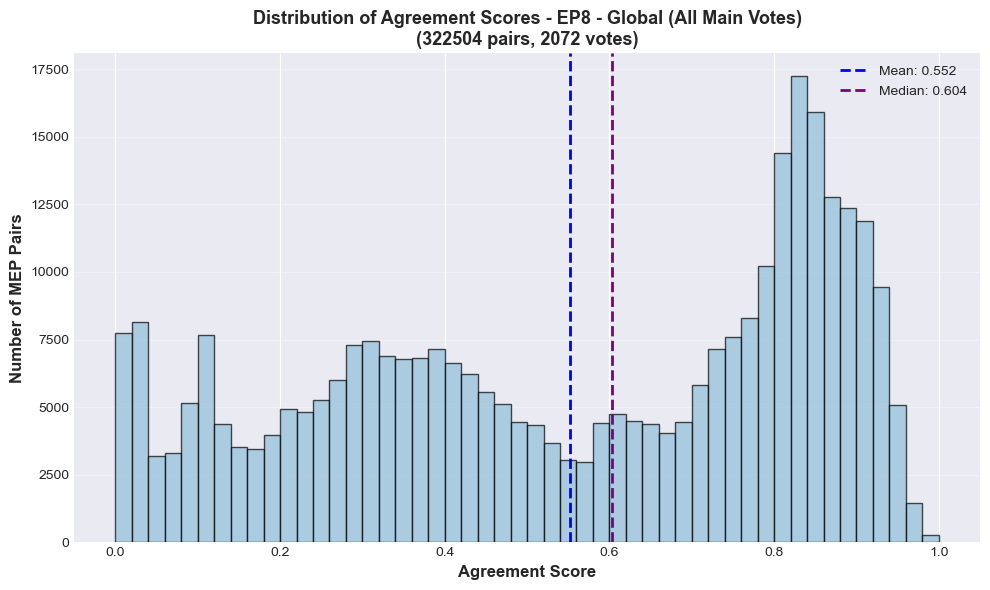

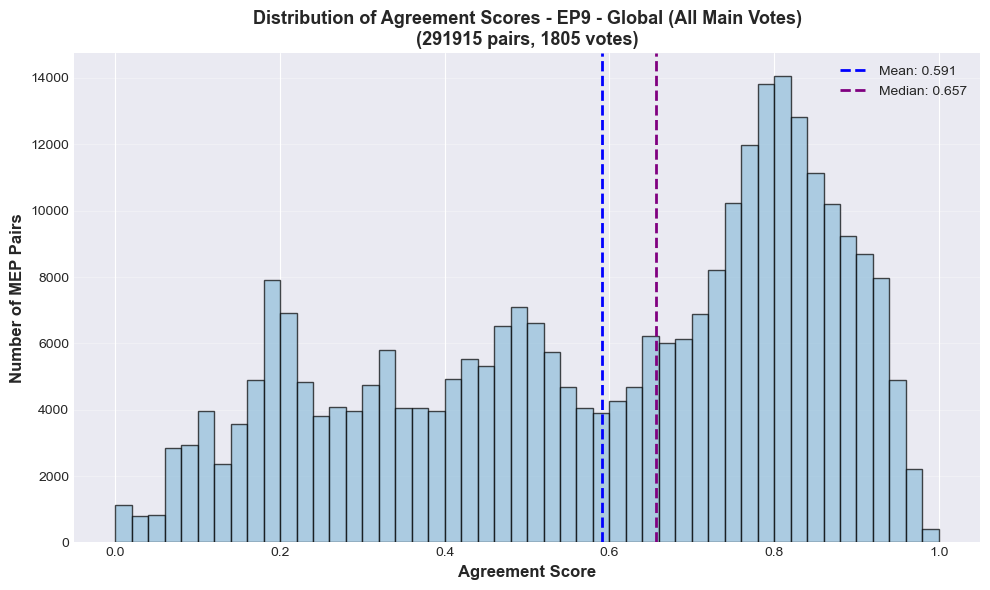

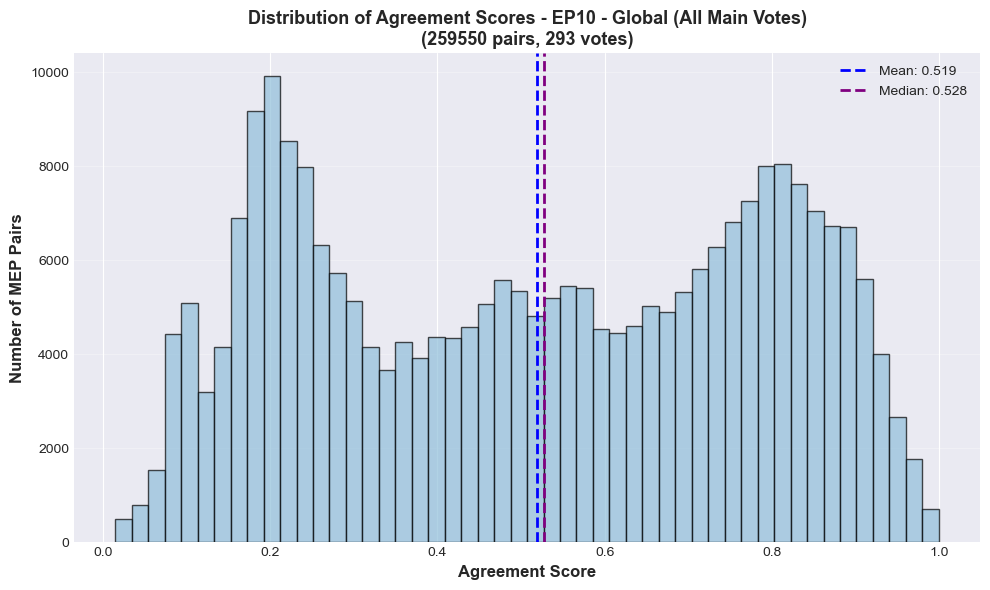

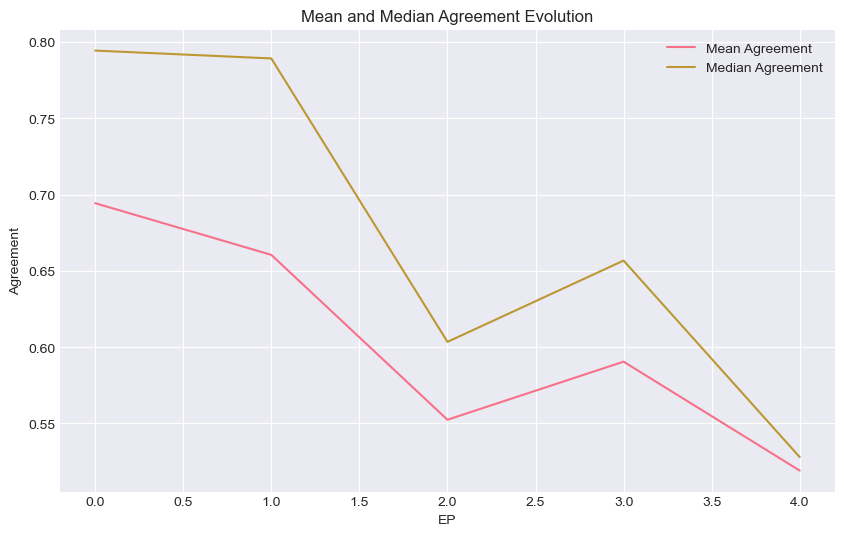

In [28]:
def plot_agreement_distribution(ep: int, topic: str = None, save_path=None):
    """
    Plot distribution of agreement scores between MEP pairs.
    
    Args:
        ep: EP number (6-10)
        topic: Topic name (None for global analysis)
        save_path: Path to save plot (None to display)
    """
    import sys
    # Add modularity_analysis to path if not already there
    mod_analysis_path = Path.cwd()
    if mod_analysis_path.name != 'modularity_analysis':
        mod_analysis_path = mod_analysis_path / "modularity_analysis"
    if str(mod_analysis_path) not in sys.path:
        sys.path.insert(0, str(mod_analysis_path))
    
    from utils import get_topic_vote_map, filter_votes_by_topic, similarity_matrix, extract_mep_metadata
    
    # Load vote data (need to adjust path if running from modularity_analysis folder)
    data_path = Path(f"data/all_votes_main_EP{ep}.csv")
    if not data_path.exists():
        # Try parent directory
        data_path = Path("..") / "data" / f"all_votes_main_EP{ep}.csv"
    
    if not data_path.exists():
        print(f"⚠️  Could not find vote data file for EP{ep}")
        return
    
    df_votes = pd.read_csv(data_path, low_memory=False)
    if df_votes is None:
        print(f"⚠️  Could not load vote data for EP{ep}")
        return
    
    # Filter by topic if specified
    if topic:
        topic_vote_map = get_topic_vote_map(ep)
        if topic not in topic_vote_map:
            print(f"⚠️  Topic '{topic}' not found for EP{ep}")
            return
        vote_ids = topic_vote_map[topic]
        df_votes = filter_votes_by_topic(df_votes, vote_ids, ep)
        title_suffix = f" - Topic: {topic}"
    else:
        title_suffix = " - Global (All Main Votes)"
    
    if df_votes.empty:
        print(f"⚠️  No vote data available")
        return
    
    # Get vote columns
    vote_cols = [c for c in df_votes.columns if c.isdigit() or c.replace(".0", "").isdigit()]
    if len(vote_cols) < 10:
        print(f"⚠️  Too few votes ({len(vote_cols)})")
        return
    
    # Filter to valid MEPs
    df_vote_subset = df_votes[vote_cols].copy()
    valid_mask = df_vote_subset.isna().sum(axis=1) < 0.7 * len(vote_cols)
    df_vote_subset = df_vote_subset.loc[valid_mask]
    
    if len(df_vote_subset) < 10:
        print(f"⚠️  Too few MEPs after filtering")
        return
    
    print(f"Computing agreement distribution for EP{ep}{title_suffix}")
    print(f"  MEPs: {len(df_vote_subset)}, Votes: {len(vote_cols)}")
    
    # Compute similarity matrix and overlap counts
    # We need to compute counts to filter out pairs with no overlapping votes
    mapping = {
        "FOR": 1,
        "AGAINST": -1,
        "ABSTENTION": 0,
        "DID_NOT_VOTE": np.nan,
        "DID_NO": np.nan,
        "DID_NOT_VOTE ": np.nan
    }
    
    V = df_vote_subset.replace(mapping).to_numpy(dtype=float)
    n = V.shape[0]
    
    yes = (V == 1).astype(float)
    no = (V == -1).astype(float)
    abst = (V == 0).astype(float)
    
    # Compute counts (number of overlapping votes per pair)
    counts = np.zeros((n, n))
    counts += yes @ yes.T + no @ no.T  # FOR-FOR, AGAINST-AGAINST
    counts += yes @ no.T + no @ yes.T  # FOR-AGAINST, AGAINST-FOR
    counts += yes @ abst.T + abst @ yes.T + no @ abst.T + abst @ no.T  # Mixed with abstention
    counts += abst @ abst.T  # ABSTENTION-ABSTENTION
    
    # Compute similarity matrix using the existing function
    A = similarity_matrix(df_vote_subset)
    
    # Extract upper triangle (avoid duplicates and diagonal)
    n = A.shape[0]
    upper_triangle_indices = np.triu_indices(n, k=1)
    agreement_values = A[upper_triangle_indices]
    overlap_counts = counts[upper_triangle_indices]
    
    # Filter out pairs with no overlapping votes (counts == 0)
    valid_mask = overlap_counts > 0
    agreement_values = agreement_values[valid_mask]
    overlap_counts = overlap_counts[valid_mask]
    
    # Diagnostic
    total_pairs = n * (n - 1) // 2
    no_overlap = total_pairs - len(agreement_values)
    exact_zeros = np.sum(agreement_values == 0)
    very_small = np.sum((agreement_values > 0) & (agreement_values < 0.01))
    
    print(f"  Total MEP pairs: {total_pairs}")
    print(f"  Pairs with no overlapping votes (excluded): {no_overlap}")
    print(f"  Pairs with overlapping votes: {len(agreement_values)}")
    print(f"  Pairs with exact 0 agreement (perfect disagreement): {exact_zeros}")
    print(f"  Pairs with agreement < 0.01 (very low): {very_small}")
    print(f"  Mean agreement: {agreement_values.mean():.4f}")
    print(f"  Median agreement: {np.median(agreement_values):.4f}")
    print(f"  Std agreement: {agreement_values.std():.4f}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Histogram with uniform color
    n_bins = 50
    counts, bins, patches = ax.hist(agreement_values, bins=n_bins, edgecolor='black', alpha=0.7, color='#91bfdb')
    
    # Add vertical lines for mean and median
    ax.axvline(agreement_values.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {agreement_values.mean():.3f}')
    ax.axvline(np.median(agreement_values), color='purple', linestyle='--', linewidth=2, label=f'Median: {np.median(agreement_values):.3f}')
    
    # store mean and median values in global variable
    mean_values.append(agreement_values.mean())
    median_values.append(np.median(agreement_values))



    ax.set_xlabel('Agreement Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of MEP Pairs', fontsize=12, fontweight='bold')
    ax.set_title(f'Distribution of Agreement Scores - EP{ep}{title_suffix}\n'
                 f'({len(agreement_values)} pairs, {len(vote_cols)} votes)', 
                 fontsize=13, fontweight='bold')
    
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        #fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved plot: {save_path}")
    else:
        plt.show()
    
    #plt.close(fig)


# Example: Plot agreement distribution for EP10, topic "budgets"
# Uncomment and modify as needed:
#plot_agreement_distribution(ep=10, topic="budgets", save_path=RESULTS_DIR / "agreement_distribution_EP10_budgets.png")
mean_values = []
median_values = []
# Or for global analysis:
for ep in range(6, 11):
    plot_agreement_distribution(ep=ep, topic=None, save_path=RESULTS_DIR / f"agreement_distribution_EP{ep}_global.png")

# plot mean and median values
plt.figure(figsize=(10, 6))
plt.plot(mean_values, label='Mean Agreement')
plt.plot(median_values, label='Median Agreement')
plt.xlabel('EP')
plt.ylabel('Agreement')
plt.title('Mean and Median Agreement Evolution')
plt.savefig(RESULTS_DIR / "mean_median_agreement_evolution.png", dpi=300, bbox_inches='tight')
plt.legend()